In [1]:
import pulp
import networkx as nx
import matplotlib.pyplot as plt

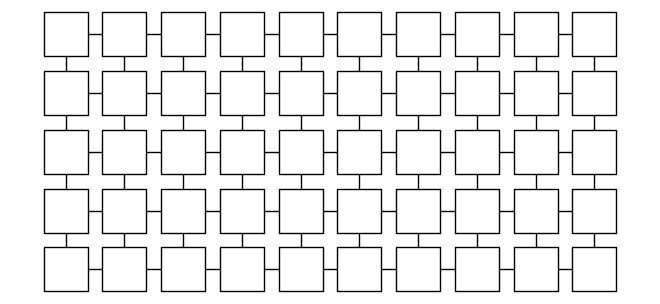

In [2]:
rows = 5
cols = 10
G = nx.grid_2d_graph(rows, cols)
pos = {(x, y): (y, -x) for x, y in G.nodes()}
nx.draw(G,
        pos,
        node_color="white",
        edgecolors="black",
        node_size=1000,
        #with_labels=True,
        node_shape='s'
       )
plt.gca().set_aspect("equal")
plt.show()

In [3]:
ORIENTATION_NAMES = [i for i in range(1,9)]
ORIENTATION_COLORS = {
    1:"#1f77b4",
    2:"#ff7f0e",
    3:"#2ca02c",
    4:"#d62728",
    5:"#9467bd",
    6:"#8c564b",
    7:"#e377c2",
    8:"#7f7f7f",
}
Y_PENTOMINO_OFFSETS = [
    [(0, -1), (0, 0), (0, 1), (0, 2), (1, 0)],
    [(0, -1), (0, 0), (0, 1), (0, 2), (-1, 0)],
    [(0, 1), (0, 0), (0, -1), (0, -2), (1, 0)],
    [(0, 1), (0, 0), (0, -1), (0, -2), (-1, 0)],
    [(-1, 0), (0, 0), (1, 0), (2, 0), (0, 1)],
    [(-1, 0), (0, 0), (1, 0), (2, 0), (0, -1)],
    [(1, 0), (0, 0), (-1, 0), (-2, 0), (0, 1)],
    [(1, 0), (0, 0), (-1, 0), (-2, 0), (0, -1)],
]
pentominoes = []
for node in G.nodes():
    x0, y0 = node
    for offsets, name in zip(Y_PENTOMINO_OFFSETS, ORIENTATION_NAMES):
        Y = [(x0 + dx, y0 + dy) for (dx, dy) in offsets]
        if all(G.has_node(v) for v in Y): 
            P=G.subgraph(Y).copy()
            P.graph["orientation"] = name       
            P.graph["color"] = ORIENTATION_COLORS[name] 
            pentominoes.append(P)
pentominoes_dict = dict(zip([i for i in range(len(pentominoes))],pentominoes))

In [4]:
# create problem
prob = pulp.LpProblem("pentomino", pulp.LpMinimize)

# x[p] = 1 pentamino p is used
x = pulp.LpVariable.dicts("x",pentominoes_dict,cat=pulp.LpBinary)

# dummy objective
prob+= 0

# each node shold be covered exactly once
for (r,c) in G.nodes():
    prob+= pulp.lpSum(x[p] for p in pentominoes_dict if (r,c) in pentominoes_dict[p].nodes()) == 1

In [5]:
prob.solve()

1

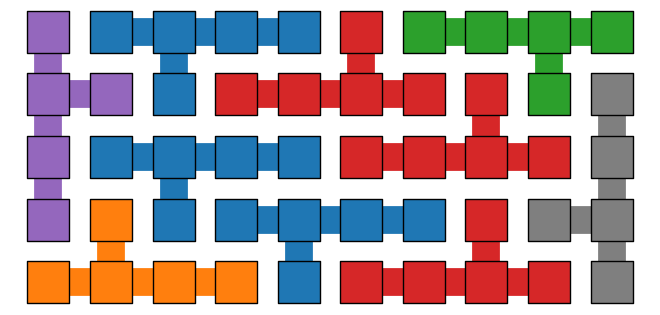

In [6]:
for p in x:
    if pulp.value(x[p])>0.9:
        P = pentominoes_dict[p]
        nx.draw(P, 
                pos, 
                node_color=P.graph["color"],
                edgecolors="black",
                edge_color=P.graph["color"],
                node_size=900,
                node_shape='s',
                width=20)
plt.gca().set_aspect("equal")
plt.show()

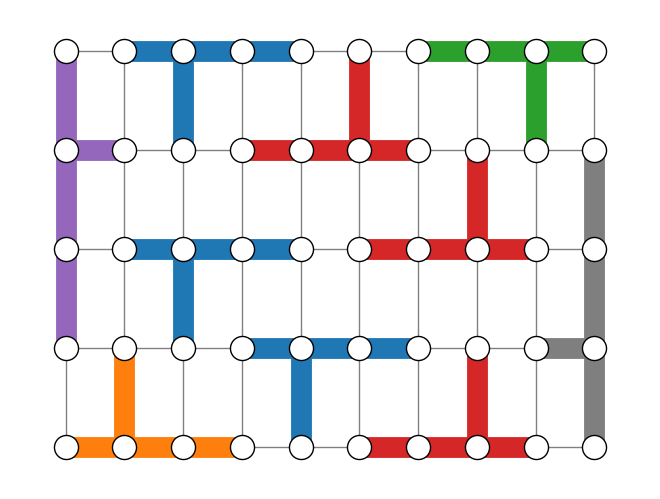

In [7]:
nx.draw(G, pos, node_size=10, edge_color='grey')
for p in x:
    if pulp.value(x[p])>0.9:
        P = pentominoes_dict[p]
        nx.draw(P, pos, 
                node_color="white",
                edgecolors="black",
                edge_color=P.graph["color"],
                width=15)